In [81]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
df = pd.read_csv("../data/ru_propaganda_2022_year/text_table_processed.csv")

In [67]:
def preprocess_dataframe(df):
    # Convert to pd.datetime
    df["Saved_datetime"] = df["Saved at"].apply(lambda row: row.split(".")[0])
    df["Saved_datetime"] = pd.to_datetime(df["Saved_datetime"])
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    df = df[df["lang"] == "ru"].reset_index(drop=True)
    df = df[~df[["Text", "Saved at", 
                 "Date", "Time"]].isna().any(axis=1)].reset_index(drop=True)
    df.drop([ "Time", "Saved at"], axis=1, inplace=True)
    return df

In [68]:
df = preprocess_dataframe(df)

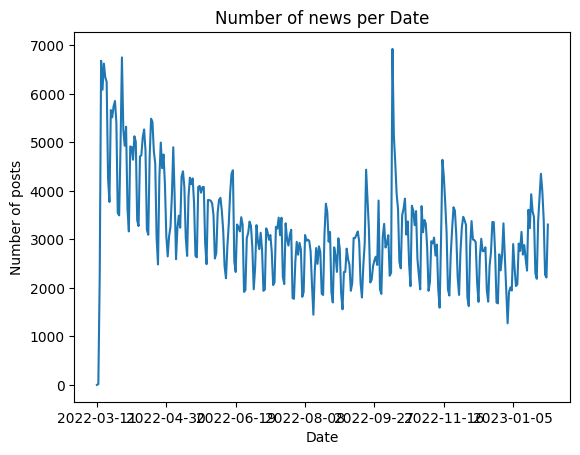

In [69]:
plt.title("Number of news per Date")
df.groupby("Date")["Text"].count().plot()
plt.xlabel("Date")
plt.ylabel("Number of posts")
plt.show()

Text(0.5, 1.0, 'Number of articles for month')

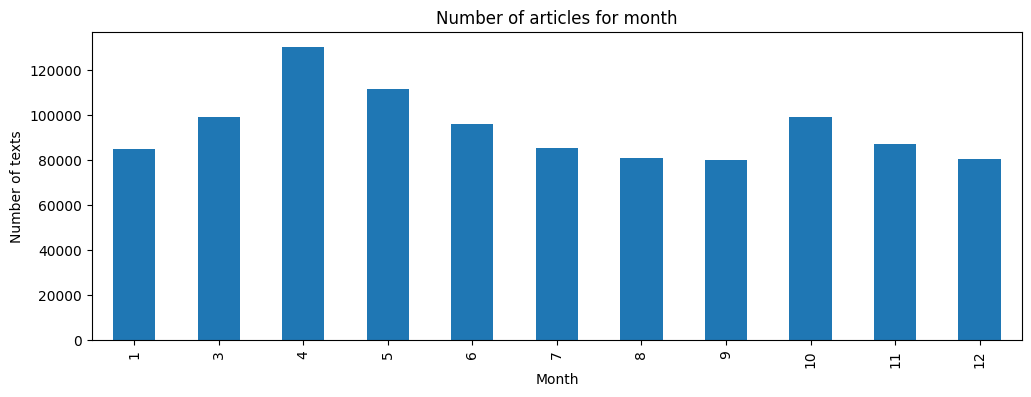

In [70]:
df['Month'] = df['DateTime'].dt.month
counts = df['Month'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
counts.plot.bar()
plt.xlabel('Month')
plt.ylabel('Number of texts')
plt.title("Number of articles for month")

Text(0.5, 1.0, 'Number of articles for day')

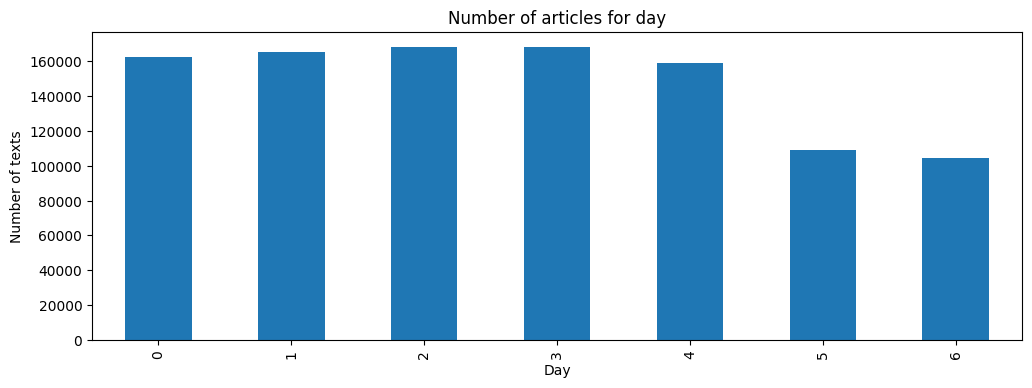

In [71]:
df['Day'] = df['DateTime'].dt.dayofweek
counts = df['Day'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
counts.plot.bar()
plt.xlabel('Day')
plt.ylabel('Number of texts')
plt.title("Number of articles for day")

In [72]:
news_embeddings = np.load("../data/ru_propaganda_2022_year/news_embeddings.npy")
assert news_embeddings.shape[0] == df.shape[0]

In [73]:
df = df[~df["Text_processed"].isna()]
news_embeddings = news_embeddings[df.index.values]
df = df.reset_index(drop=True)

In [80]:
nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
en_stopwords = stopwords.words("english")
stop_words = ru_stopwords + en_stopwords

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words=stop_words,
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df["Text_processed"])

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerdurden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


vectorization done in 26.921 s
n_samples: 1035538, n_features: 176404


In [89]:
kmeans = KMeans(
    n_clusters=2,
    max_iter=100,
    n_init=5,
).fit(X_tfidf)

In [94]:
kmeans

KMeans(max_iter=100, n_clusters=2, n_init=5)

In [93]:
sns.scatterplot(kmeans)

TypeError: object of type 'KMeans' has no len()